# Initial Setup


In [1]:
import tensorflow as tf           # Tensorflow
import numpy as np                # Numpy
import matplotlib                # Matplotlib
import matplotlib.pyplot as plt   # Pyplot

# Versions:
print("TensorFlow: ", tf.__version__)           # Tensorflow version
print("Numpy     : ", np.__version__)                # Numpy Version
print("Matplotlib: ", matplotlib.__version__)   # Matplotlib version

TensorFlow:  2.19.0
Numpy     :  2.0.2
Matplotlib:  3.10.0


# Hyperparameters


In [2]:
T0 = 30 # Body inital temperature
Ts = 10 # Surrounding temperature
k = 0.4 # Constant
N_data = 12 # Number of data points
N_pde = 100 # Number of pde points
lambda_data = 0.05 # Data loss weight
lambda_pde = 20 # PDE loss weight
lambda_bc = 0.2 # Boundary condition loss weight

# Data Generation

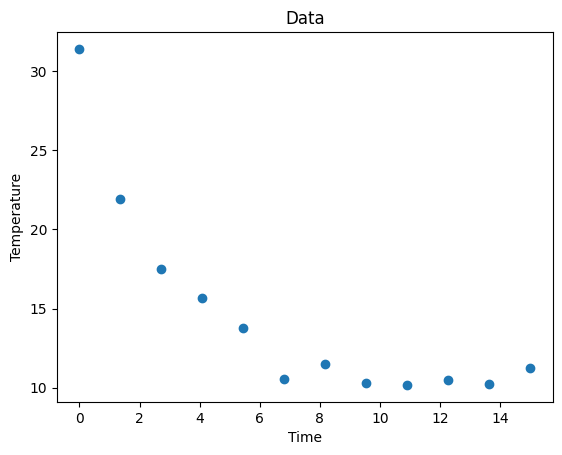

In [3]:
def analytical_solution(t):
  return Ts + (T0-Ts)*np.exp(-k*t)

np.random.seed(0) # Seed
noise_level = 0.8 # Noise amplitude
#t = np.random.uniform(0, 15, N_data).reshape(-1, 1)
t = np.linspace(0, 15, N_data).reshape(-1, 1) # time for data points
t_pde = np.linspace(0, 15, N_pde).reshape(-1, 1) # time for pde points
#t = np.logspace(0, 1.1, N_data).reshape(-1, 1)
T_data = analytical_solution(t).reshape(-1, 1) + noise_level*np.random.randn(N_data, 1) # Temperature data
# Plotting the data
plt.plot(t, T_data, 'o')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Data')
plt.show()
# Convert to Pyotch tensors:
t = tf.convert_to_tensor(t, dtype=tf.float32)
t_pde = tf.convert_to_tensor(t_pde, dtype=tf.float32)
T_data = tf.convert_to_tensor(T_data, dtype=tf.float32)

# PINN

In [4]:
class PINN(tf.keras.Model):
  def __init__(self, n_hidden_layers, n_neurons):
    super(PINN, self).__init__()
    self.hidden = [ tf.keras.layers.Dense( n_neurons, activation='tanh') for _ in range(n_hidden_layers)] # Hidden layers
    self.out = tf.keras.layers.Dense(1, activation=None, dtype = tf.float32) # Output layer

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    return self.out(x)
# Instantiate the model:
model = PINN( n_hidden_layers=3, n_neurons=50) # 3 hidden layers, 50 neurons per layer
# Model information:
#model.build(input_shape=(None, 1))  # Input dimension = 1
#model.summary()

# Loss

In [5]:
def residue(model, t): # Calculates the pde residue
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(t)
    T_pred = model(t) # Predicted temperature
    T_pred_t = tape.gradient(T_pred, t) # Temperature gradient --> first derivative in relation with time
  del tape
  return T_pred_t + k*(T_pred - Ts) # return the residue

def loss(model, t, t_pde):
  res = residue(model, t_pde) # Calculates the residue
  #tf.print("res = ", res)
  loss_pde = tf.reduce_mean(lambda_pde*tf.square(res)) # Calculates the pde residue loss
  loss_data = tf.reduce_mean(lambda_data*tf.square(model(t) - T_data)) # Calculates the data loss
  t_0 = np.array([[0.0]], dtype=np.float32)
  t_0 = tf.convert_to_tensor(t_0, dtype=tf.float32)
  T_0 = np.array([[T0]], dtype=np.float32)
  T_0 = tf.convert_to_tensor(T_0, dtype=tf.float32)
  loss_bc = tf.reduce_mean(lambda_bc*tf.square(model(t_0) - T_0)) # Calculates the boundary condition loss
  total_loss = loss_data + loss_pde + loss_bc # Calculates the weighted total loss
  return loss_pde, loss_data, loss_bc, total_loss

# Training

In [6]:
@tf.function # Compiles in a tensorflow graph to performance
def train_step(model, t, t_pde, optimizer):
  with tf.GradientTape() as tape: # Auto diferentitation recorded for back propagation
    loss_pde, loss_data, loss_bc, loss_value = loss(model, t, t_pde) # Calculates the loss
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss_pde, loss_data, loss_bc, loss_value

epochs = 500
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = [] # Loss history
for epoch in range(epochs):
    loss_pde, loss_data, loss_bc, loss_value = train_step(model, t, t_pde, optimizer)
    loss_history.append(loss_value)
    if epoch % 500 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch}, PDE Loss: {loss_pde.numpy():.5f}, Data Loss: {loss_data.numpy():.5f}, BC Loss: {loss_bc.numpy():.5f}, Total Loss: {loss_value.numpy():.5f}")


Epoch 0, PDE Loss: 305.43600, Data Loss: 12.28918, BC Loss: 180.00000, Total Loss: 497.72519
Epoch 499, PDE Loss: 0.00293, Data Loss: 0.04364, BC Loss: 0.00025, Total Loss: 0.04682


# Results

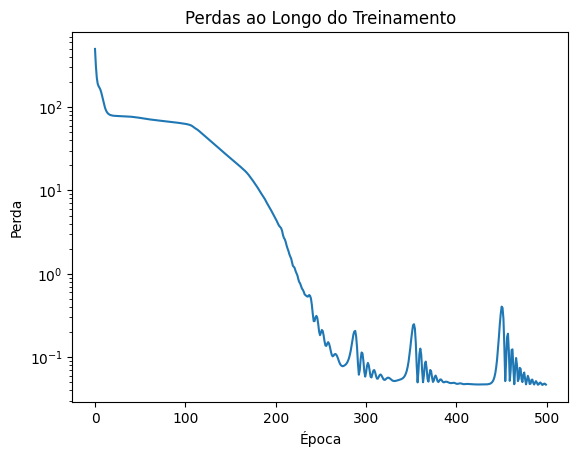

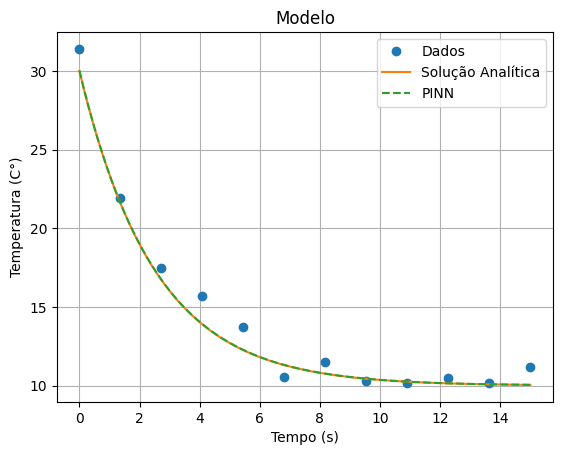

In [7]:
# Loss through the epochs:
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perdas ao Longo do Treinamento')
plt.show()


# Predict values
t_plot = np.linspace(0, 15, 200).reshape(-1, 1)
t_plot_tf = tf.convert_to_tensor(t_plot, dtype=tf.float32)
T_pred = model(t_plot_tf).numpy()

# True analytical solution
T_exact = analytical_solution(t_plot)

# Plot
plt.plot(t, T_data.numpy(), 'o', label='Dados')
plt.plot(t_plot, T_exact, label='Solução Analítica')
plt.plot(t_plot, T_pred, '--', label='PINN')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (C°)')
plt.title('Modelo')
plt.legend()
plt.grid(True)
plt.show()
